In [47]:
import pandas as pd
import numpy as np
from numpy import cumsum
import re

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cbook as cbook

import datetime
from datetime import date
from datetime import datetime
from datetime import timedelta

import warnings
import statistics
warnings.filterwarnings("ignore")

today_date = datetime.strptime('2021-08-18', "%Y-%m-%d").date()

### LOAD DATAFRAME

You can find both these datasets in the 'data' folder.

In [31]:
df_set = pd.read_csv('./data/singles.csv')
df_box = pd.read_csv('./data/boxes.csv')

df_set['date'] = pd.to_datetime(df['date'],format='%Y-%m-%d')
df_set['date'] = pd.to_datetime(df['date']).dt.date

df_box['date'] = pd.to_datetime(df_box['date'],format='%Y-%m-%d')
df_box['date'] = df_box['date'].dt.date

### FILTER DATAFRAME

#### MODERN HORIZONS 2

In [36]:
#LOADING SPECIAL CARDS
sheet_url = 'https://docs.google.com/spreadsheets/d/1Xa-EuwjX5o7K8Ywgeb9qsaFY_zCv6gW4WdveXrT4h4Q/gviz/tq?tqx=out:csv&sheet=CSV'
df_special_cards = pd.read_csv(sheet_url)

special_cards = df_special_cards.card.unique()

len(special_cards)

48

In [48]:
special_filter = pd.DataFrame()
for special_card in special_cards:
  scard = df_set.loc[(df_set['card_name'].str.contains(special_card)) & (df_set['date'] == today_date) & (df_set['card_name'].str.contains('V.2')==False)]
  special_filter = special_filter.append(scard, ignore_index=True)

mythic_filter = df_set.loc[(df_set['rarity'] == 'Mythic') & (df_set['card_name'].str.contains("(V.2)")==False)]
rare_filter = df_set.loc[(df_set['rarity'] == 'Rare') & (df_set['card_name'].str.contains("(V.2)")==False)]

concat_ev = pd.concat([special_filter, mythic_filter,rare_filter])
df_ev = pd.DataFrame(concat_ev, columns=['date','card_set','rarity','card_name','price','availability','price_foil','availability_foil'])

### CALCULATIONS

Calculating different pricing datapoints.

In [50]:
# AVERAGE PRICE

avg_price = df_ev.groupby(['date','rarity'])['price'].mean().reset_index(name='avg_price')
avg_pricefoil = df_ev.groupby(['date','rarity'])['price_foil'].mean().reset_index(name='avg_price_foil')


# MEDIAN PRICE

median_prices = df_ev.groupby(['date','rarity'])['price'].median().reset_index(name='median_price')
median_pricesfoil = df_ev.groupby(['date','rarity'])['price_foil'].median().reset_index(name='median_price_foil')


# CALCULATING ESTIMATED VALUE (EV) OF A BOX

box_ev_calc = avg_price.merge(avg_pricefoil, on=['date','rarity'])
box_ev_calc = box_ev_calc.merge(median_prices, on=['date','rarity'])
box_ev_calc = box_ev_calc.merge(median_pricesfoil, on=['date','rarity'])

box_ev_calc['box_ev'] = 0
box_prices = df_box.loc[df_box['box_name'].str.contains("Modern Horizons 2 Draft")][["date", "box_price"]]

box_ev_calc.loc[box_ev_calc['rarity'] == 'Time Shifted', 'avg_ev'] = box_ev_calc['avg_price']*36
box_ev_calc.loc[box_ev_calc['rarity'] == 'Mythic', 'avg_ev'] = box_ev_calc['avg_price']*3
box_ev_calc.loc[box_ev_calc['rarity'] == 'Rare', 'avg_ev'] = box_ev_calc['avg_price']*33

median_prices.loc[median_prices['rarity'] == 'Time Shifted', 'median_ev'] = median_prices['median_price']*36
median_prices.loc[median_prices['rarity'] == 'Mythic', 'median_ev'] = median_prices['median_price']*3
median_prices.loc[median_prices['rarity'] == 'Rare', 'median_ev'] = median_prices['median_price']*33

df_median_ev = median_prices.groupby(['date'])['median_ev'].sum().reset_index(name='median_ev')
df_box_ev = box_ev_calc.groupby(['date'])['avg_ev'].sum().reset_index(name='avg_ev')
df_box_ev = df_box_ev.merge(df_median_ev, on='date')
df_box_ev = df_box_ev.merge(box_prices, on='date')

#### PRINTING LAST DATE'S STATISTICS

Statistical information about the last recorded date.

In [51]:
print("Mean Price - Mythic")
print(round(mythic_filter.loc[mythic_filter['date'] == today_date]['price'].mean(), 2))
print("Standard Deviation - Mythic")
print(round(statistics.pstdev(mythic_filter.loc[mythic_filter['date'] == today_date]['price'].to_numpy()),2))
print("Variance - Mythic")
print(round(statistics.pvariance(mythic_filter.loc[mythic_filter['date'] == today_date]['price'].to_numpy()),2))
print("------")
print("Mean Price - Rare")
print(round(rare_filter.loc[rare_filter['date'] == today_date]['price'].mean(),2))
print("Standard Deviation - Rare")
print(round(statistics.pstdev(rare_filter.loc[rare_filter['date'] == today_date]['price'].to_numpy()),2))
print("Variance - Rare")
print(round(statistics.pvariance(rare_filter.loc[rare_filter['date'] == today_date]['price'].to_numpy()),2))
print("------")
print("Mean Price - Special")
print(round(special_filter.loc[special_filter['date'] == today_date]['price'].mean(),2))
print("Standard Deviation - Special")
print(round(statistics.pstdev(special_filter.loc[special_filter['date'] == today_date]['price'].to_numpy()), 2))
print("Variance - Special")
print(round(statistics.pvariance(special_filter.loc[special_filter['date'] == today_date]['price'].to_numpy()),2))

Mean Price - Mythic
8.86
Standard Deviation - Mythic
11.52
Variance - Mythic
132.77
------
Mean Price - Rare
2.55
Standard Deviation - Rare
6.32
Variance - Rare
39.93
------
Mean Price - Special
3.37
Standard Deviation - Special
7.44
Variance - Special
55.35


### PREPARING BOX PRICES DATA

In [52]:
df_box_ev['box_price'] = df_box_ev['box_price'].astype(np.float64)
# That was easy!

### PLOTTING THE CHART - VISUALISING THE DATA

By charting the dataset, we can quickly see where we stand and where are the opportunities and pitfalls.

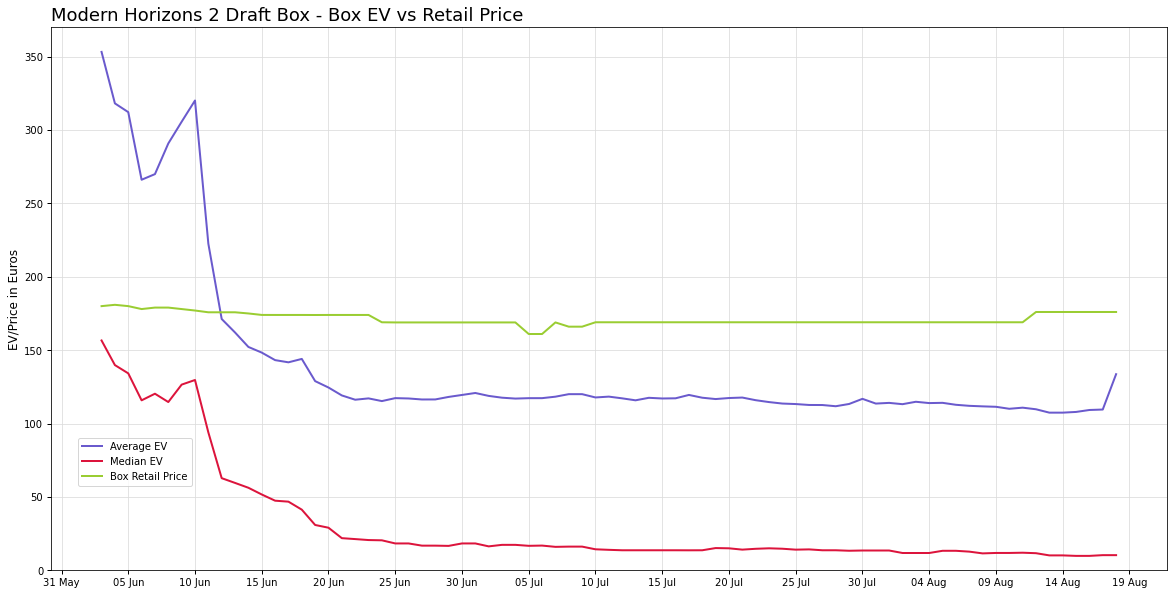

In [80]:
fig, ax = plt.subplots(figsize=(20,10))

day_span = 7

plt.plot(df_box_ev['date'][day_span:],df_box_ev['avg_ev'][day_span:], lw=2.0, label='Average EV', color="slateblue")
plt.plot(df_box_ev['date'][day_span:],df_box_ev['median_ev'][day_span:], lw=2.0, label='Median EV', color="crimson")
plt.plot(df_box_ev['date'][day_span:],df_box_ev['box_price'][day_span:], lw=2.0, label='Box Retail Price', color="yellowgreen")
    
plt.title('Modern Horizons 2 Draft Box - Box EV vs Retail Price', fontsize=18, color='black', loc="left")
plt.ylabel("EV/Price in Euros", fontsize=12, color='black')
ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))
ax.get_xaxis().set_major_formatter(mdates.DateFormatter("%d %b"))
plt.legend(loc='center left', bbox_to_anchor=(0.02, 0.2))
#plt.yticks(np.arange(find_card['price']), max(find_card['price']), 14.0)
ax.set_ylim(ymin=0) ## SETTING AXIS TO 0
plt.tick_params(direction='out', length=4, width=1, colors='black')
plt.grid(True, color='gainsboro')
plt.show()

### BOX GENERATOR

This function will generate a box for X number of times (function input). It will calculate the estimated value - the expect value of every card inside the box, which will help players to understand if there's good returns in opening boxes of a set.

In [74]:
mythic_filter_today = df_set.loc[(df_set['rarity'] == 'Mythic') & (df_set['date'] == today_date) & (df_set['card_name'].str.contains("(V.2)")==False)]
rare_filter_today = df_set.loc[(df_set['rarity'] == 'Rare') & (df_set['date'] == today_date) & (df_set['card_name'].str.contains("(V.2)")==False)]
special_filter_today = special_filter.loc[special_filter['date'] == today_date]

def box_generator(times):
    global boxes_model
    box_generated = []
    boxes_model = []
    for boxes_to_generate in range(times):
        for mythics in range(3):
            mythic_row = mythic_filter_today['price'].sample()
            mythic_v = mythic_row.iloc[0]
            box_generated.append(mythic_v)
        for rares in range(33):
            rare_row = rare_filter_today['price'].sample()
            rare_v = rare_row.iloc[0]
            box_generated.append(rare_v)
        for specials in range(36):
            special_row = special_filter_today['price'].sample()
            special_v = special_row.iloc[0]
            box_generated.append(special_v)
        one_box_ev = sum(box_generated)
        boxes_model.append(one_box_ev)
        box_generated = []
    #print(boxes_model)
    print('-Average Price Per Box: €'+str(sum(boxes_model) // len(boxes_model)))
    print('-Standard Deviation: '+str(statistics.pstdev(boxes_model)))
    print('-Min. Box EV: €' +str(min(boxes_model).round(2)))
    print('-Max. Box EV: €' +str(max(boxes_model).round(2)))

In [78]:
box_generator(10000)

-Average Price Per Box: €232.0
-Standard Deviation: 60.57174925032912
-Min. Box EV: €48.09
-Max. Box EV: €493.97


#### BOXES DISTRIBUTION (HISTOGRAM)

What are the chances of recouping our investment?

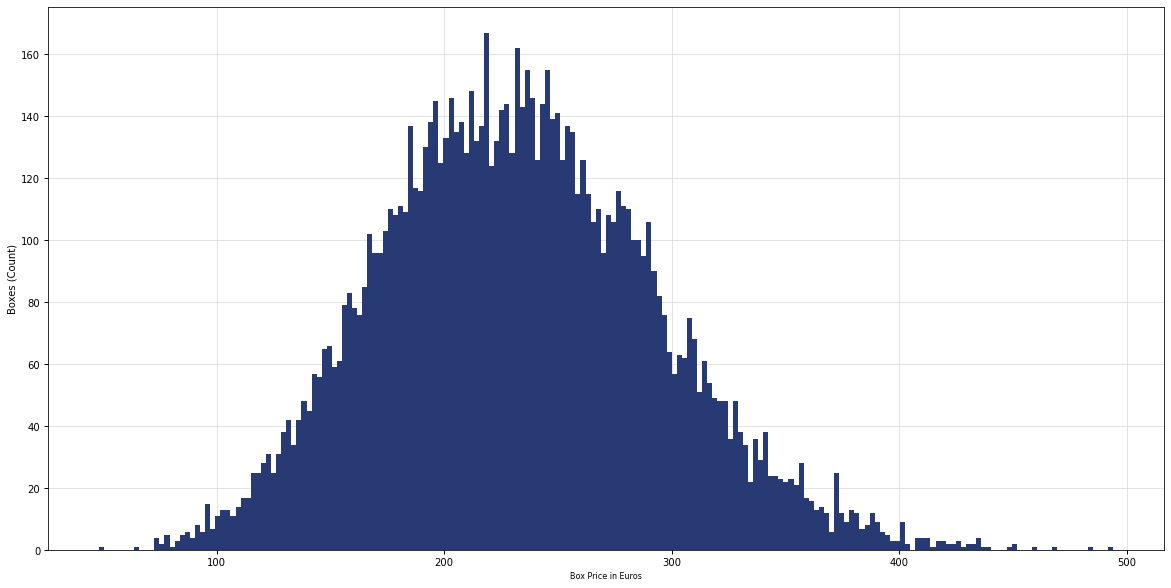

In [79]:
counts, bins = np.histogram(boxes_model)

fig, ax = plt.subplots(figsize=(20,10))
plt.hist(boxes_model, density=False, bins=200, color='#273a74')  # density=False would make counts
plt.tick_params(direction='out', length=4, width=1, colors='black')

plt.ylabel("Boxes (Count)", fontsize=10, color='black')
plt.xlabel("Box Price in Euros", fontsize=8, color='black')
ax.set_axisbelow(True)
plt.grid(True, color='gainsboro', zorder=0)
plt.show()